# Week 10: Logistic Regression and Generalized Linear Models

### Neil D. Lawrence

### 1st December 2015

In [2]:
import numpy as np
import pandas as pd
import pods
import matplotlib.pyplot as plt
%matplotlib inline

### Review

* Last week: Specified Class Conditional Distributions, $p(\mathbf{x}_i|y_i, \boldsymbol{\theta})$.
* Used Bayes Classifier + naive Bayes model to specify joint distribtuion.
* Used Bayes rule to compute posterior probability of class membership.
* This week: 
    * direct estimation of probability of class membership.
    * introduction of generalised linear models.


### Logistic Regression and GLMs

* Modelling entire density allows any question to be answered (also missing data).
* Comes at the possible expense of *strong* assumptions about data generation distribution.
* In regression we model probability of $y_i |\mathbf{x}_i$ directly.
    * **Allows less flexibility in the question, but more flexibility in the model assumptions.**
* Can do this not just for regression, but classification.
* Framework is known as *generalized linear models*.

## Log Odds

* model the *log-odds* with the basis functions.
* [odds](http://en.wikipedia.org/wiki/Odds) are defined as the ratio of the probability of a positive outcome, to the probability of a negative outcome. 
* Probability is between zero and one, odds are:
    $$ \frac{\pi}{1-\pi} $$
* Odds are between $0$ and $\infty$. 
* Logarithm of odds maps them to $-\infty$ to $\infty$.

### Logit Link Function

* The [Logit function](http://en.wikipedia.org/wiki/Logit), $$g^{-1}(\pi_i) = \log\frac{\pi_i}{1-\pi_i}.$$ This function is known as a *link function*.

* For a standard regression we take,
    $$f(\mathbf{x}_i) = \mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x}_i),$$
* For classification we perform a logistic regression. 
    $$\log \frac{\pi_i}{1-\pi_i} = \mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x}_i)$$

### Inverse Link Function

We have defined the link function as taking the form $g^{-1}(\cdot)$ implying that the inverse link function is given by $g(\cdot)$. Since we have defined,
$$
g^{-1}(\pi) = \mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})
$$
we can write $\pi$ in terms of the *inverse link* function, $g(\cdot)$ as 
$$
\pi = g(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})).
$$

In [ ]:
def predict(w, x, basis=linear, **kwargs):
    "Generates the prediction function and the basis matrix."
    Phi = basis(x, **kwargs)
    f = np.dot(Phi, w)
    return 1./(1+np.exp(-f)), Phi

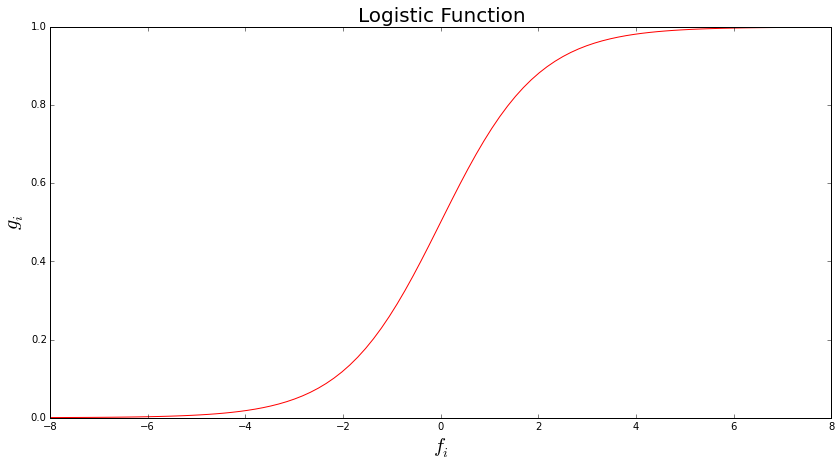

In [9]:
fig, ax = plt.subplots(figsize=(14,7))
f = np.linspace(-8, 8, 100)
g = 1/(1+np.exp(-f))

ax.plot(f, g, 'r-')
ax.set_title('Logistic Function', fontsize=20)
ax.set_xlabel('$f_i$', fontsize=20)
ax.set_ylabel('$g_i$', fontsize=20)
plt.savefig('./diagrams/logistic.svg')

This inverse of the link function is known as the [logistic](http://en.wikipedia.org/wiki/Logistic_function) (thus the name logistic regression) or sometimes it is called the sigmoid function. For a particular value of the input to the link function, $f_i = \mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x}_i)$ we can plot the value of the link function as below.
![](./diagrams/logistic.svg)

### Sigmoid Function

* Logistic takes input from the entire real line and 'squashes' it between 0 and 1 it is sometimes also called a 'squashing function'. 

* Can now write $\pi$ as a function of the input and the parameter vector as, $$\pi(\mathbf{x},\mathbf{w}) = \frac{1}{1+ \exp\left(-\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})\right)}.$$

* Compute the output of a standard linear basis function composition ($\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})$, as we did for linear regression)

* Apply the inverse link function, $g(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x}))$. 

* Use this value in a Bernoulli distribution to form the likelihood. 

### Bernoulli Reminder

* From last time $$P(y_i|\mathbf{w}, \mathbf{x}) = \pi_i^{y_i} (1-\pi_i)^{1-y_i}$$

* Trick for switching betwen probabilities
```python
def bernoulli(y, pi):
    if y == 1:
        return pi
    else:
        return 1-pi
```

### Maximum Likelihood

* Conditional independence of data:$$P(\mathbf{y}|\mathbf{w}, \mathbf{X}) = \prod_{i=1}^n P(y_i|\mathbf{w}, \mathbf{x}_i). $$
* Log likelihood
$$\log P(\mathbf{y}|\mathbf{w}, \mathbf{X}) = \sum_{i=1}^n \log P(y_i|\mathbf{w}, \mathbf{x}_i) = \sum_{i=1}^n y_i \log \pi_i + \sum_{i=1}^n (1-y_i)\log (1-\pi_i)$$

### Objective Function

* Probability of positive outcome for the $i$th data point $$\pi_i = g\left(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x}_i)\right),$$ where $g(\cdot)$ is the *inverse* link function

* Objective function of the form $$E(\mathbf{w}) = -  \sum_{i=1}^n y_i \log g\left(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x}_i)\right) - \sum_{i=1}^n(1-y_i)\log \left(1-g\left(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x}_i)\right)\right).$$

In [ ]:
def objective(g, y):
    "Computes the objective function."
    return np.log(g[y.values, :]).sum() + np.log(1-g[~y.values, :]).sum()


### Minimize Objective

* Grdient wrt  $\pi(\mathbf{x};\mathbf{w})$ 
$$
\frac{\text{d}E(\mathbf{w})}{\text{d}\mathbf{w}} = -\sum_{i=1}^n \frac{y_i}{g\left(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})\right)}\frac{\text{d}g(f_i)}{\text{d}f_i} \boldsymbol{\phi(\mathbf{x}_i)} +  \sum_{i=1}^n \frac{1-y_i}{1-g\left(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})\right)}\frac{\text{d}g(f_i)}{\text{d}f_i} \boldsymbol{\phi(\mathbf{x}_i)}
$$

### Link Function Gradient

* Also need gradient of inverse link function wrt parameters.
\begin{align*}
g(f_i) &= \frac{1}{1+\exp(-f_i)}\\
&=(1+\exp(-f_i))^{-1}
\end{align*}
and the gradient can be computed as
\begin{align*}
\frac{\text{d}g(f_i)}{\text{d} f_i} & = \exp(-f_i)(1+\exp(-f_i))^{-2}\\
& = \frac{1}{1+\exp(-f_i)} \frac{\exp(-f_i)}{1+\exp(-f_i)} \\
& = g(f_i) (1-g(f_i))
\end{align*}

### Objective Gradient

$$
\frac{\text{d}E(\mathbf{w})}{\text{d}\mathbf{w}} = -\sum_{i=1}^n y_i\left(1-g\left(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})\right)\right) \boldsymbol{\phi(\mathbf{x}_i)} +  \sum_{i=1}^n (1-y_i)\left(g\left(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})\right)\right) \boldsymbol{\phi(\mathbf{x}_i)}.
$$

### Optimization of the Function

* Can't find a stationary point of the objective function analytically.

* Optimization has to proceed by *numerical methods*. 
    * [Newton's method](http://en.wikipedia.org/wiki/Newton%27s_method) or 
    * [gradient based optimization methods](http://en.wikipedia.org/wiki/Gradient_method) 
    
* Similarly to matrix factorization, for large data *stochastic gradient descent*  (Robbins Munroe optimization procedure) works well. 

### Ad Matching for Facebook

* This approach used in many interent companies.

* Example: ad matching for Facebook.
    * Millions of advertisers
    * Billions of users
    * How do you choose who to show what?
    
* Logistic regression used in combination with [decision trees]()

* [Paper available here](http://www.herbrich.me/papers/adclicksfacebook.pdf)

### Other GLMs

* Logistic regression is part of a family known as *generalized linear models*

* They all take the form $$g^{-1}(f_i(x)) = \mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x}_i)$$

* As another example let's look at *Poisson regression*.



### Poisson Distribution

* Poisson distribution is used for 'count data'. For non-negative integers, $y$, $$P(y) = \frac{\lambda^y}{y!}\exp(-y)$$

* Here $\lambda$ is a *rate* parameter that can be thought of as the number of arrivals per unit time.

* Poisson distributions can be used for disease count data. E.g. number of incidence of malaria in a district.


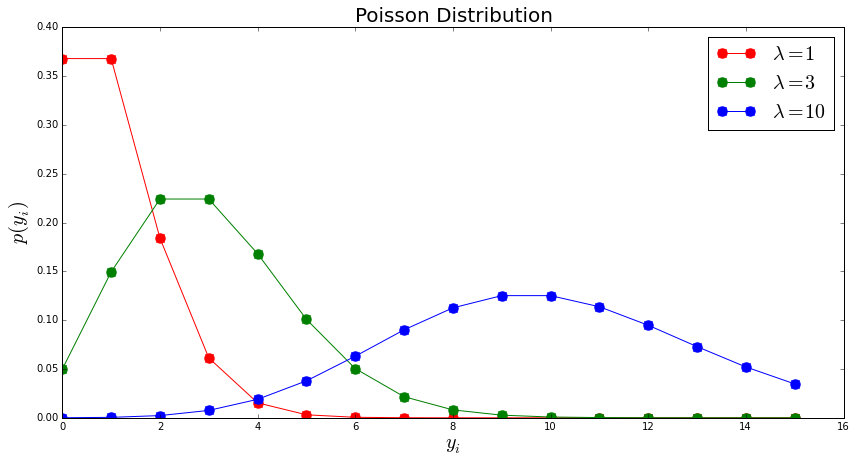

In [25]:
from scipy.stats import poisson
fig, ax = plt.subplots(figsize=(14,7))
y = np.asarray(range(0, 16))
p1 = poisson.pmf(y, mu=1.)
p3 = poisson.pmf(y, mu=3.)
p10 = poisson.pmf(y, mu=10.)

ax.plot(y, p1, 'r.-', markersize=20, label='$\lambda=1$')
ax.plot(y, p3, 'g.-', markersize=20, label='$\lambda=3$')
ax.plot(y, p10, 'b.-', markersize=20, label='$\lambda=10$')
ax.set_title('Poisson Distribution', fontsize=20)
ax.set_xlabel('$y_i$', fontsize=20)
ax.set_ylabel('$p(y_i)$', fontsize=20)
ax.legend(fontsize=20)
plt.savefig('./diagrams/poisson.svg')


### Poisson Distribution

![](./diagrams/poisson.svg)

### Poisson Regression

* In a Poisson regression make rate a function of space/time.$$\log \lambda(\mathbf{x}, t) = \mathbf{w}_x^\top \boldsymbol{\phi_x(\mathbf{x})} + \mathbf{w}_t^\top \boldsymbol(\phi_t(t))$$

* This is known as a *log linear* or *log additive* model. 

* The link function is a logarithm.

* We can rewrite such a function as 
$$\log \lambda(\mathbf{x}, t) = f_x(\mathbf{x}) + f_t(t)$$

### Multiplicative Model

* Be careful though ... a log additive model is really multiplicative.
$$\log \lambda(\mathbf{x}, t) = f_x(\mathbf{x}) + f_t(t)$$

* Becomes $$\lambda(\mathbf{x}, t) = \exp(f_x(\mathbf{x}) + f_t(t))$$

* Which is equivalent to  $$\lambda(\mathbf{x}, t) = \exp(f_x(\mathbf{x}))\exp(f_t(t))$$

* Link functions can be deceptive in this way.